In [1]:
import os, sys

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

from env_variables import *
from dataset.loading import DataLoader
from lib.esn import ESN

import numpy as np
import random
import warnings
from matplotlib import pyplot as plt

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

In [2]:
data_path = '../../../'
cache_dir = '../../cache/'
dl = DataLoader(data_path, cache_dir)

dr = []
speakers = []
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10

XorZ = "X"

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+path_option
if len(speakers):
    path_option = str(len(speakers))+path_option

features_train, labels_train, _ = dl.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


In [3]:
from dataset.data_processing import *

phonemes, features_train, labels_train = filter_data(features_train, labels_train, limit=None)

Filtered to 177080 samples of shape (10, 14)


In [4]:
from matplotlib.ticker import FuncFormatter
from experiments.helpers.experiment_helpers import *
from sklearn.base import BaseEstimator, ClassifierMixin
from matplotlib.lines import Line2D

# Add this function to your code
def integer_formatter(x, pos):
    return '%1.0f' % x

class Classifier(BaseEstimator, ClassifierMixin):

    def __init__(self,
                 W_in_scale,
                 b_scale,
                 spectral_radius,
                 weights):
        self.W_in_scale = W_in_scale
        self.spectral_radius = spectral_radius
        self.b_scale = b_scale
        self.weights = weights

        self.n_mels = None
        self.XorZ = None
        self.N = None
        self.n_samples = None
        self.classes = None
        self.esn = None
        self.Cs_clas = None
        self.Ns_clas = None

    def fit(self, X, y, **params):
        self.n_mels = params["n_mels"]
        self.XorZ = params["XorZ"]
        self.N = params["N"]

        # Group data by class
        group = group_by_labels(X, y)

        self.classes = list(group.keys())
        self.n_samples = sum([len(x) for x in list(group.values())])

        print(f"Number of samples: {self.n_samples}")
        # Init Reservoir
        esn_params = {
            "in_dim": self.n_mels,
            "out_dim": self.n_mels,
            "N": self.N,
            "W_in_scale": self.W_in_scale,
            "b_scale": self.b_scale,
            "spectral_radius": self.spectral_radius,
            "weights": self.weights
        }
        self.esn = ESN(esn_params)

        Cs = []
        for _, signals in group.items():
            X = run_all(self.esn, signals, XorZ)
            Cs.append(compute_c(X, 1))
        ss_list = [ [sum_of_singular_vals(C)] for C in Cs ]
        init_sum = np.mean([x[0] for x in ss_list])
        Cs = optimize_apertures(Cs, start=0.001, end=500, n=150)

        #### Plotting apertures

        target_sum = np.mean([sum_of_singular_vals(C) for C in Cs])
        st = np.std([sum_of_singular_vals(C) for C in Cs])
        debug_print("Target: ", target_sum)
        debug_print("std", st)
        Cs, ss_list_2 = adapt_singular_vals_of_Cs(Cs, target_sum, debug=True)
        ss_list = [ ss_list[i] + ss_list_2[i] for i in range(len(ss_list)) ]
        #Ns = Ns_from_Cs(Cs)

        plt.figure(figsize=(10,7))
        plt.gcf().set_dpi(150)
        for ss in ss_list:
            plt.plot(ss)
        x_max = max([len(ss) for ss in ss_list]) - 1
        ax = plt.gca()
        plt.tick_params(axis='both', which='major', labelsize=default_font_size)
        def custom_formatter(x, pos):
            if x == init_sum:
                return r'$\overline{tr_0} \approx$' + f'{x:.2f}'  # Adjust number of decimal places as needed
            elif x == target_sum:
                return r'$tr_{target} \approx$' + f'{x:.2f}'  # Adjust number of decimal places as needed
            else:
                return str(x)


        # Setting ticks and labels
        midpoint_ticks = np.arange(0.5, x_max, 1)
        ax.set_xticks(midpoint_ticks)
        ax.set_xticklabels(range(1, len(midpoint_ticks) + 1), fontsize=default_font_size)
        ax.yaxis.set_ticks(np.sort(list(range(0,70,10)) + [target_sum] + [init_sum]), fontsize=default_font_size)
        ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
        # Custom gridlines
        for tick in np.arange(0.5, x_max+1, 1):
            ax.axvline(x=tick-0.5, color='gray', linestyle='-', linewidth=0.5, alpha=0.7)

        plt.ylabel('Trace', fontsize = default_font_size)
        plt.xlabel('Adaptation step', fontsize = default_font_size)
        # Change to normal gray lines
        plt.axhline(y=target_sum, color='gray', linestyle='-', linewidth=0.5, alpha=0.7)
        plt.axhline(y=init_sum, color='gray', linestyle='-', linewidth=0.5, alpha=0.7)

        legend_elements = [
            Line2D([0], [0], color='gray', lw=2, label=r'Trace of one positive conceptor')
        ]

        ax.legend(handles=legend_elements, loc='lower right', fontsize=default_font_size)
        plt.ylim(bottom=0)
        plt.grid(axis='y')  # we only want horizontal gridlines
        plt.show()


        # Return the classifier
        return self

    def predict(self, X):
        y = []
        for sample in X:
            x = self.esn.run(sample.T, XorZ=self.XorZ)
            es = evidences_for_Cs(x,self.Cs_clas,self.Ns_clas)
            if self.XorZ == "X":
                es = [ np.sum(p) for p in es ]
            y.append(self.classes[np.argmax(es)])

        return y

Number of samples: 177080
Computing gammas...
Optimal gamma:  136.50700084225218
Target:  57.22889944914817
std 1.368486380625429


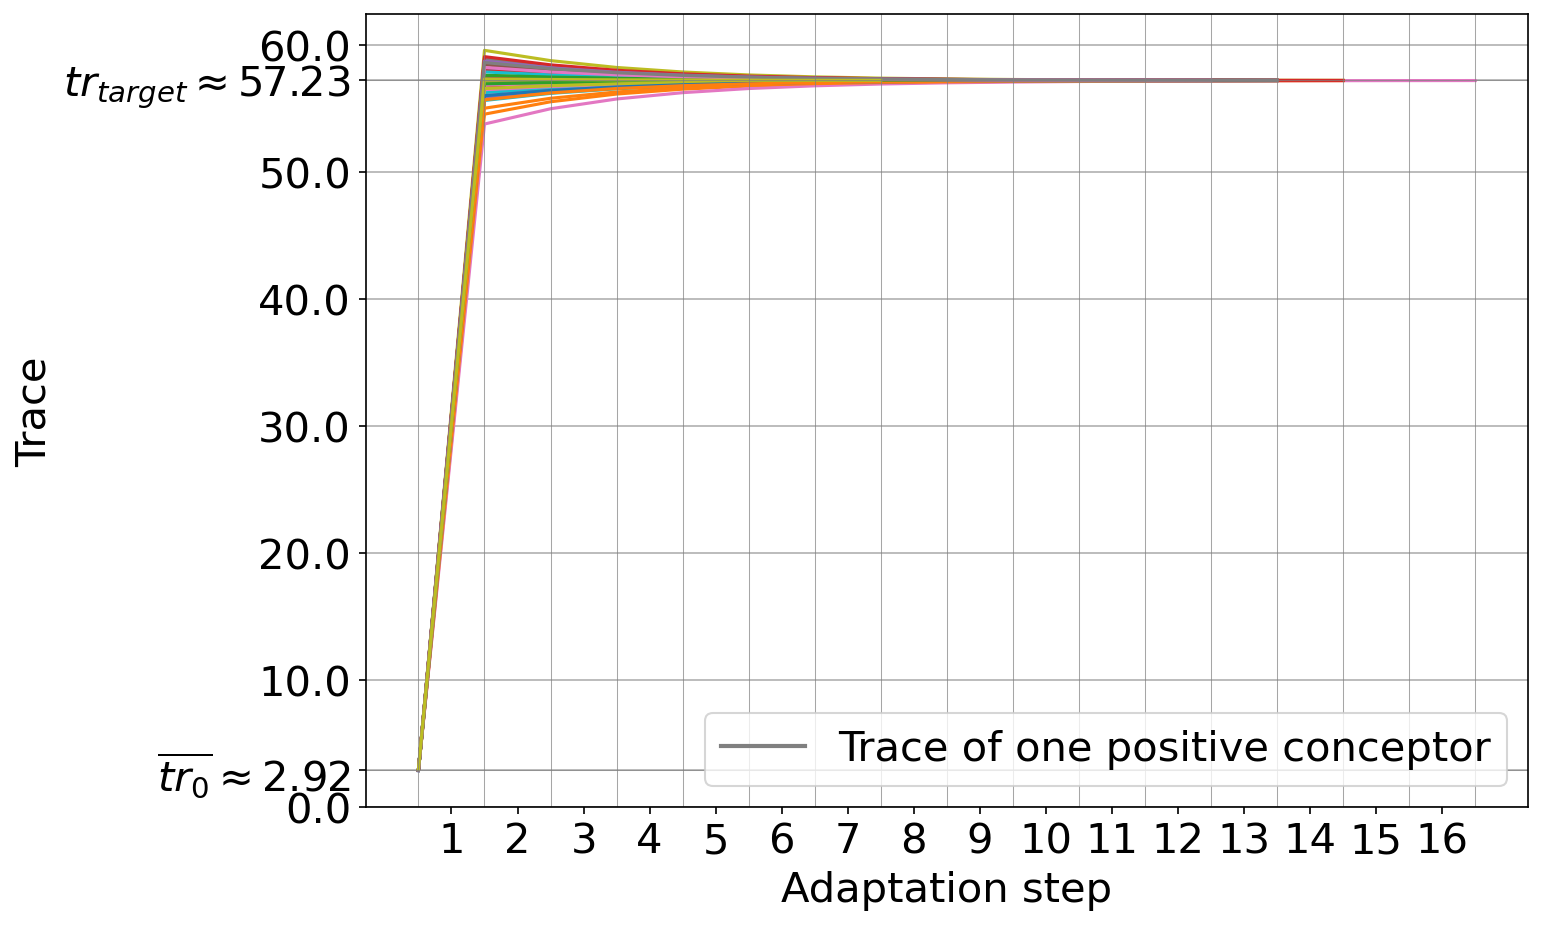

In [5]:
clas = Classifier(W_in_scale=1.1,
                 b_scale=.6,
                 spectral_radius=2.57,
                 weights=.1)

_ = clas.fit(features_train, labels_train, **{
    "n_mels": n_mels,
    "XorZ": "X",
    "N": 100,
    "cache": False
})

# clas.fit(features_train, labels_train, **{
#     "n_mels": n_mels,
#     "XorZ": "X",
#     "N": 20
# })